# Explore here

In [41]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Corrección aquí
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, SeparableConv2D, Flatten, Dense, Input, Dropout, BatchNormalization, Lambda, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.optimizers import Adam 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

## Carga del conjunto de datos 

In [ ]:
os.makedirs('../data/raw/', exist_ok=True)
os.system('kaggle competitions download -c dogs-vs-cats -p ../data/raw/')
os.system('unzip ../data/raw/dogs-vs-cats.zip -d ../data/raw/')
os.system('unzip ../data/raw/train.zip -d ../data/raw/')

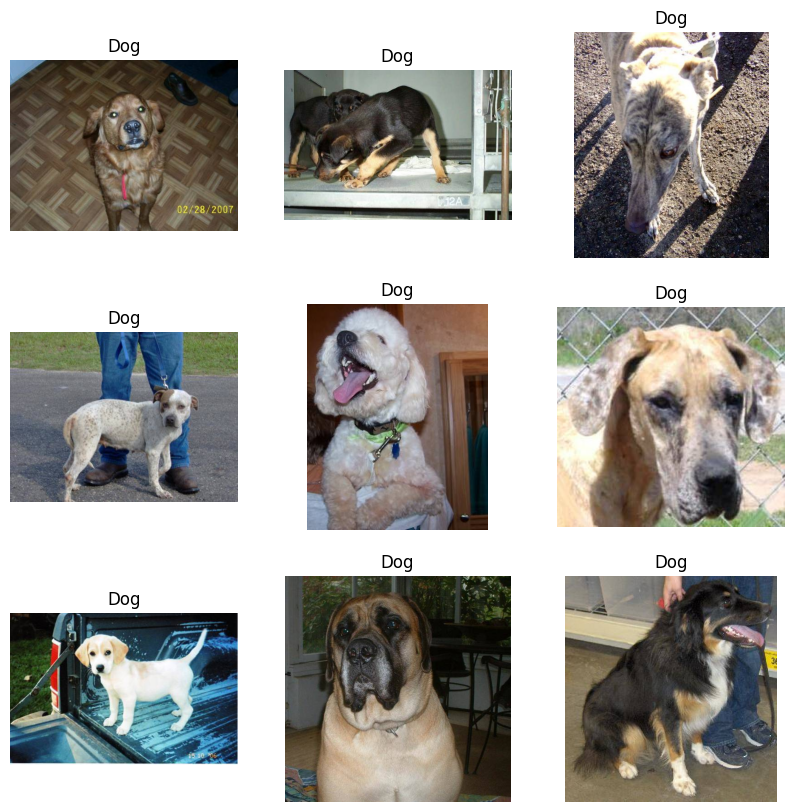

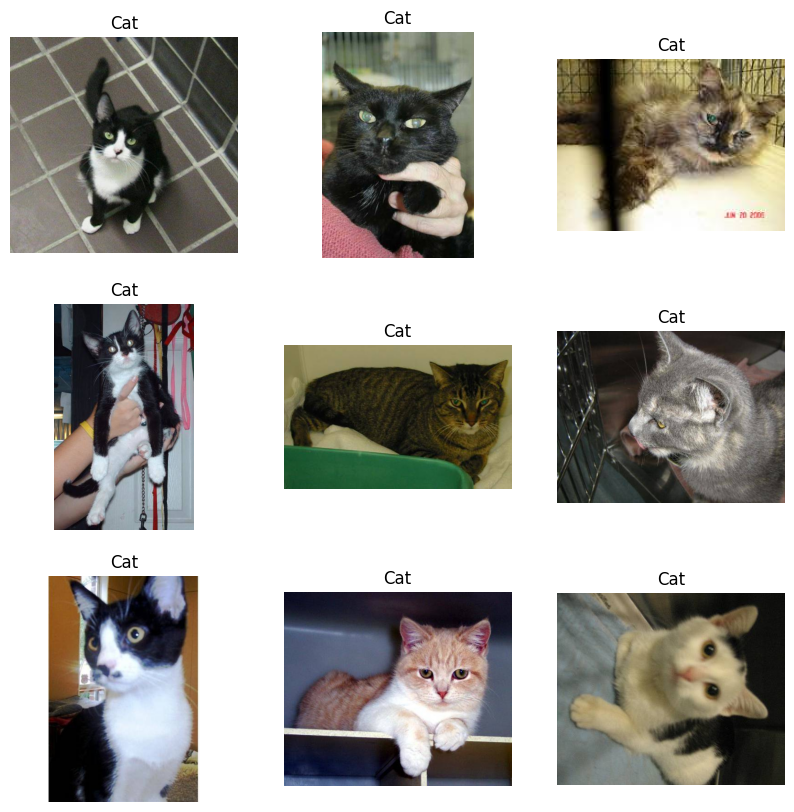

In [11]:
train_dir = "../data/raw/train"
dog_images = [os.path.join(train_dir, f) for f in os.listdir(train_dir) if 'dog' in f][:9]
cat_images = [os.path.join(train_dir, f) for f in os.listdir(train_dir) if 'cat' in f][:9]

plt.figure(figsize=(10, 10))
for i, img_path in enumerate(dog_images):
        plt.subplot(3, 3, i + 1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title('Dog')
        plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
for i, img_path in enumerate(cat_images):
        plt.subplot(3, 3, i + 1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title('Cat')
        plt.axis('off')
plt.show()

## Generadores de datos

In [13]:
filenames = os.listdir('../data/raw/train/')
print(filenames[:20])

['dog.3448.jpg', 'cat.6349.jpg', 'cat.8826.jpg', 'cat.2553.jpg', 'cat.9923.jpg', 'cat.3452.jpg', 'cat.1506.jpg', 'dog.9068.jpg', 'dog.641.jpg', 'cat.5078.jpg', 'cat.6764.jpg', 'cat.4072.jpg', 'dog.8803.jpg', 'dog.7714.jpg', 'cat.4587.jpg', 'cat.6174.jpg', 'cat.11175.jpg', 'dog.3683.jpg', 'cat.4792.jpg', 'cat.659.jpg']


In [14]:
categories = []
for filename in filenames:
        category = filename.split('.')[0]
        if category == 'dog':
            categories.append('0')  # Convierte 0 a '0'
        else:
            categories.append('1')  # Convierte 1 a '1'

df = pd.DataFrame({
        'filename': filenames,
        'category': categories
    })

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='../data/raw/train/',
        x_col='filename',
        y_col='category',
        target_size=(150, 150),
        batch_size=8,
        class_mode='binary',
        subset='training',
        seed=42,
        workers=4)

validation_generator = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='../data/raw/train/',
        x_col='filename',
        y_col='category',
        target_size=(150, 150),
        batch_size=8,
        class_mode='binary',
        subset='validation',
        seed=42)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory='../data/raw/train/',
        x_col='filename',
        y_col='category',
        target_size=(150, 150),
        batch_size=8,
        class_mode='binary',
        shuffle=False)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 25000 validated image filenames belonging to 2 classes.


## Construcción del Modelo RNA

In [46]:
model = Sequential([
        Input(shape=(200, 200, 3)),
        SeparableConv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        SeparableConv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        SeparableConv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        GlobalAveragePooling2D(),
        Dense(units=512, activation="relu"),
        Dropout(0.5),
        Dense(units=1, activation="sigmoid")
])
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Entreno del modelo

In [27]:
history = model.fit(train_generator, epochs=1, validation_data=validation_generator)

   3/2500 ━━━━━━━━━━━━━━━━━━━━ 7:14 174ms/step - accuracy: 0.5278 - loss: 0.7346

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7039 - loss: 0.5769

/home/vscode/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 369s 147ms/step - accuracy: 0.7039 - loss: 0.5768 - val_accuracy: 0.7220 - val_loss: 0.5497


## Evalucación del modelo

In [28]:
loss, accuracy = model.evaluate(test_generator)
print(f'Loss: {loss}, Accuracy: {accuracy}')

   1/3125 ━━━━━━━━━━━━━━━━━━━━ 2:50 54ms/step - accuracy: 0.3750 - loss: 1.0089

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 99s 32ms/step - accuracy: 0.7277 - loss: 0.5434
Loss: 0.5403123497962952, Accuracy: 0.7308800220489502


In [31]:
print(history.history)

{'accuracy': [0.7171499729156494], 'loss': [0.5572314262390137], 'val_accuracy': [0.722000002861023], 'val_loss': [0.549713134765625]}


## Guardar Modelo

In [44]:
model.save("../models/photo.h5")

print("Modelo guardado en: ../models/photo.h5")

Modelo guardado en: ../models/photo.h5


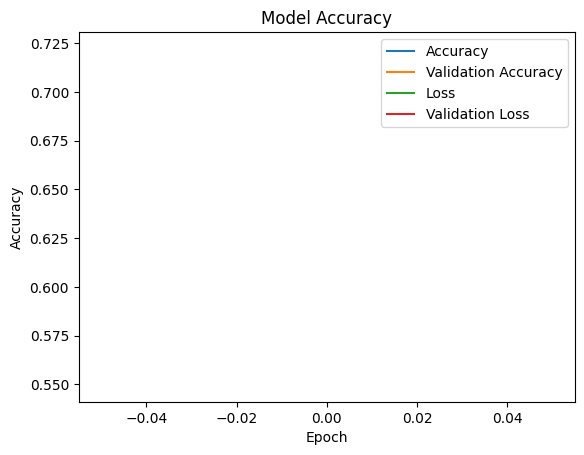

In [36]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

# Configurar el diseño del gráfico
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])

# Trazar
plt.show()

## Predicción de imágenes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
dog


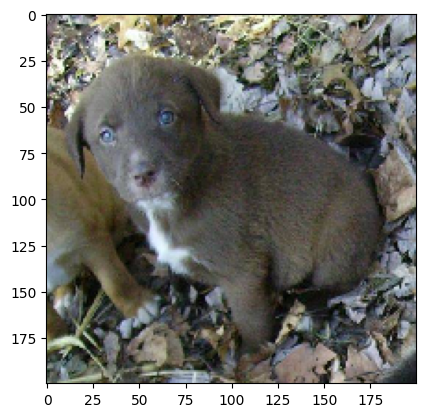

: 

In [ ]:
from keras.preprocessing import image
from keras.models import load_model

img = image.load_img("../data/raw/test/2555.jpg", target_size = (200, 200))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis = 0)
saved_model = load_model("../models/photo.h5")
output = saved_model.predict(img)
if output[0][0] > output[0][0]:
    print("cat")
else:
    print("dog")